**Section 3 Part 2**
Zeyad Mohamed Fayed 222102242

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import os 



DATASET_PATH = "/kaggle/input/Digital_Music.csv"


if not os.path.exists(DATASET_PATH):
    
    DATASET_PATH = "/kaggle/input/digital-music-csv/Digital_Music.csv"

print(f"📂 Loading data from: {DATASET_PATH}")
ratings = pd.read_csv(DATASET_PATH, header=None, names=['user_id', 'product_id', 'rating', 'timestamp'])


min_ratings = 5
user_counts = ratings['user_id'].value_counts()
active_users = user_counts[user_counts >= min_ratings].index
ratings_filtered = ratings[ratings['user_id'].isin(active_users)].copy()


ratings_filtered['user_code'] = ratings_filtered['user_id'].astype('category').cat.codes
ratings_filtered['item_code'] = ratings_filtered['product_id'].astype('category').cat.codes

n_users = ratings_filtered['user_code'].nunique()
n_items = ratings_filtered['item_code'].nunique()

user_item_sparse = csr_matrix(
    (np.ones(len(ratings_filtered)), 
    (ratings_filtered['user_code'], ratings_filtered['item_code'])),
    shape=(n_users, n_items)
)

print(f"✅ Matrix Created. Users: {n_users}, Items: {n_items}")


print("⏳ Computing Co-occurrence Matrix (Sparse Dot Product)...")
co_occurrence_matrix = user_item_sparse.dot(user_item_sparse.T)
co_occurrence_matrix.setdiag(0)
co_occurrence_matrix.eliminate_zeros()


print("⏳ Calculating Statistics per User...")


max_common = co_occurrence_matrix.max(axis=1).toarray().flatten()


sum_common = co_occurrence_matrix.sum(axis=1).A1
avg_common = sum_common / (n_users - 1)


min_common = np.zeros(n_users)

for i in range(n_users):
    start_ptr = co_occurrence_matrix.indptr[i]
    end_ptr = co_occurrence_matrix.indptr[i+1]
    
    if start_ptr < end_ptr:
        row_data = co_occurrence_matrix.data[start_ptr:end_ptr]
        if len(row_data) > 0:
            min_common[i] = row_data.min()
    else:
        min_common[i] = 0


user_categories = ratings_filtered['user_id'].astype('category').cat.categories

stats_df = pd.DataFrame({
    'user_id': user_categories,
    'avg_common': avg_common,
    'max_common': max_common,
    'min_common_nonzero': min_common
})

stats_df['feature_vector'] = stats_df.apply(
    lambda row: [round(row['avg_common'], 4), int(row['max_common']), int(row['min_common_nonzero'])], 
    axis=1
)


output_dir = "/kaggle/working/Clustering Results"
output_file = "user_corating_statistics.csv"
output_path = os.path.join(output_dir, output_file)


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"📁 Directory created: {output_dir}")


print("💾 Saving results to CSV...")
stats_df.to_csv(output_path, index=False)

print(f"✅ File successfully saved at: {output_path}")


print("\n📊 First 5 rows of the result:")
print(stats_df[['user_id', 'feature_vector']].head(20))

📂 Loading data from: /kaggle/input/Digital_Music.csv
✅ Matrix Created. Users: 50110, Items: 581591
⏳ Computing Co-occurrence Matrix (Sparse Dot Product)...
⏳ Calculating Statistics per User...
💾 Saving results to CSV...
✅ File successfully saved at: /kaggle/working/Clustering Results/user_corating_statistics.csv

📊 First 5 rows of the result:
       user_id  feature_vector
0   0001377647  [0.0011, 2, 1]
1   0001388703  [0.0008, 2, 1]
2   0001526146  [0.0005, 2, 1]
3   0001527134  [0.0004, 3, 1]
4   0006882919     [0.0, 1, 1]
5   0006920055  [0.0011, 2, 1]
6   0006935257  [0.0004, 3, 1]
7   0545109620  [0.0001, 2, 1]
8   0615165982     [0.0, 0, 0]
9   0615897398     [0.0, 0, 0]
10  0760103453  [0.0001, 1, 1]
11  0760131694     [0.0, 0, 0]
12  0760135886  [0.0005, 3, 1]
13  0763420565     [0.0, 0, 0]
14  0819815802     [0.0, 0, 0]
15  0830838015  [0.0004, 2, 1]
16  0875420230     [0.0, 1, 1]
17  0879465298     [0.0, 1, 1]
18  0899575935  [0.0002, 1, 1]
19  090100829X     [0.0, 0, 0]


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os



feature_cols = ['avg_common', 'max_common', 'min_common_nonzero']
X = stats_df[feature_cols].values



scaler = StandardScaler()


X_normalized = scaler.fit_transform(X)


stats_df['norm_avg'] = X_normalized[:, 0]
stats_df['norm_max'] = X_normalized[:, 1]
stats_df['norm_min'] = X_normalized[:, 2]


stats_df['normalized_feature_vector'] = stats_df[['norm_avg', 'norm_max', 'norm_min']].values.tolist()



output_dir = "/kaggle/working/Clustering Results"
output_file = "user_normalized_stats.csv"
output_path = os.path.join(output_dir, output_file)


if not os.path.exists(output_dir):
    os.makedirs(output_dir)


print("💾 Saving normalized data to CSV...")
stats_df.to_csv(output_path, index=False)

print(f"✅ Normalized file saved at: {output_path}")


print("\n📊 Verification Statistics (Should be Mean~0, Std~1):")
print(stats_df[['norm_avg', 'norm_max', 'norm_min']].agg(['mean', 'std']).round(4))

print("\n✅ Top 5 Users with Normalized Vectors:")
print(stats_df[['user_id', 'normalized_feature_vector']].head())

💾 Saving normalized data to CSV...
✅ Normalized file saved at: /kaggle/working/Clustering Results/user_normalized_stats.csv

📊 Verification Statistics (Should be Mean~0, Std~1):
      norm_avg  norm_max  norm_min
mean      0.00      0.00      0.00
std       1.00      1.00      1.00

✅ Top 5 Users with Normalized Vectors:
      user_id                          normalized_feature_vector
0  0001377647  [-0.24480601888132505, -0.18394118270193752, 0...
1  0001388703  [-0.2791325484002537, -0.18394118270193752, 0....
2  0001526146  [-0.31874008246055596, -0.18394118270193752, 0...
3  0001527134  [-0.3398641006260505, -0.05724822618888527, 0....
4  0006882919  [-0.3821121369570396, -0.3106341392149897, 0.1...


⏳ Calculating Elbow Curve...
✅ Elbow plot saved to: /kaggle/working/Clustering Results/elbow_curve_plot.png


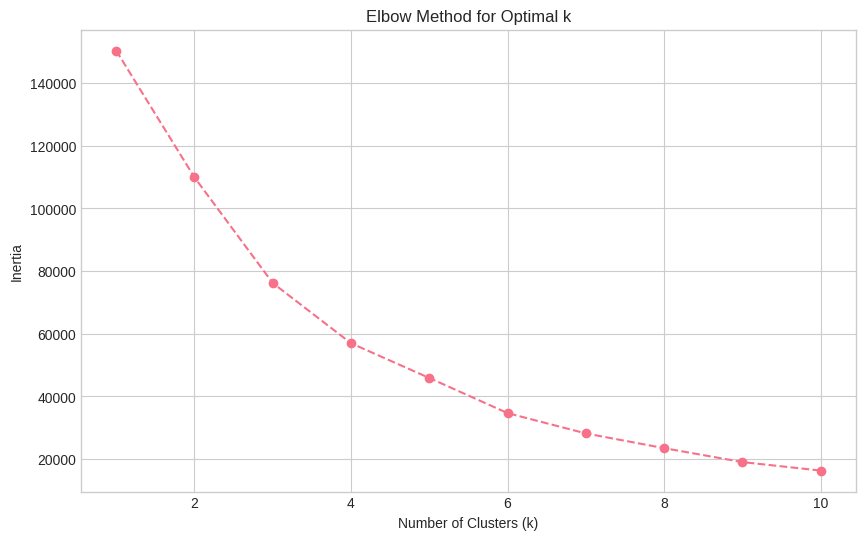


🚀 Applying K-Means with k=4...

✅ Cluster Summary (Mean values of original features):
               avg_common  max_common  min_common_nonzero  user_count
cluster_label                                                        
0                    0.00        0.00                0.00        2187
1                    0.00        2.73                1.01       45785
2                    0.04      148.62                1.04          73
3                    0.03       17.90                1.01        2065
✅ Cluster summary saved to: /kaggle/working/Clustering Results/cluster_summary.csv
✅ Labeled dataset saved to: /kaggle/working/Clustering Results/users_with_clusters.csv
✅ Pairplot saved to: /kaggle/working/Clustering Results/clusters_pairplot.png


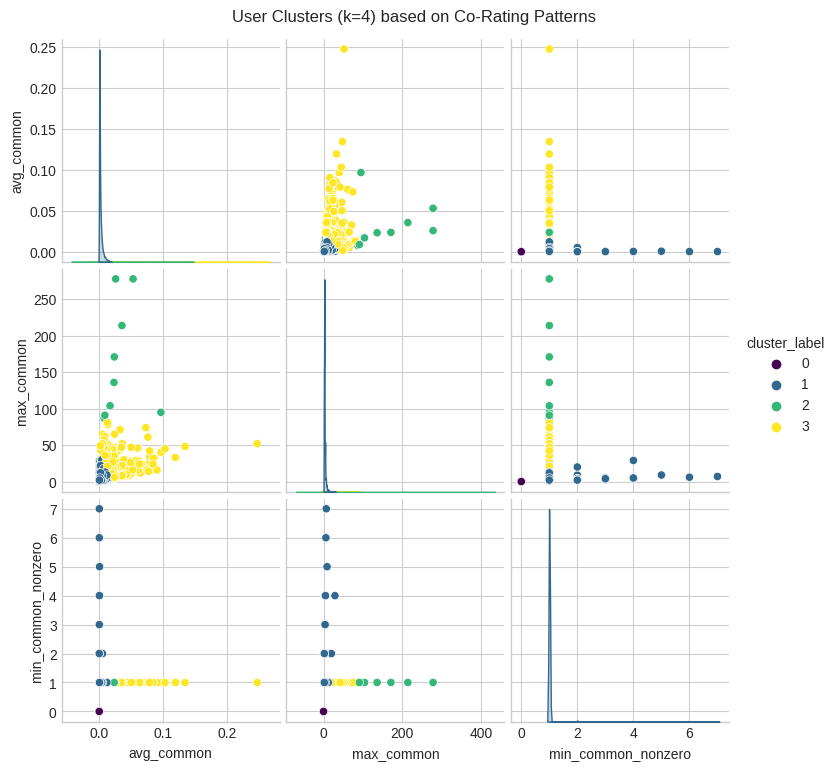

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


print("⏳ Calculating Elbow Curve...")
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)


elbow_plot_path = os.path.join(output_dir, "elbow_curve_plot.png")
plt.savefig(elbow_plot_path)
print(f"✅ Elbow plot saved to: {elbow_plot_path}")

plt.show()


optimal_k = 4  
print(f"\n🚀 Applying K-Means with k={optimal_k}...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
stats_df['cluster_label'] = kmeans.fit_predict(X_normalized)


cluster_summary = stats_df.groupby('cluster_label')[['avg_common', 'max_common', 'min_common_nonzero', 'user_id']].agg({
    'avg_common': 'mean',
    'max_common': 'mean',
    'min_common_nonzero': 'mean',
    'user_id': 'count'
}).rename(columns={'user_id': 'user_count'})

print("\n✅ Cluster Summary (Mean values of original features):")
print(cluster_summary.round(2))

# 💾 Save Cluster Summary to CSV
summary_path = os.path.join(output_dir, "cluster_summary.csv")
cluster_summary.to_csv(summary_path)
print(f"✅ Cluster summary saved to: {summary_path}")

# 💾 Save Full Labeled Data (البيانات كاملة مع رقم الكلاستر)
labeled_data_path = os.path.join(output_dir, "users_with_clusters.csv")
stats_df.to_csv(labeled_data_path, index=False)
print(f"✅ Labeled dataset saved to: {labeled_data_path}")


plot_sample = stats_df.sample(min(10000, len(stats_df)), random_state=42)

pair_plot = sns.pairplot(
    plot_sample, 
    vars=['avg_common', 'max_common', 'min_common_nonzero'], 
    hue='cluster_label', 
    palette='viridis'
)
pair_plot.fig.suptitle(f"User Clusters (k={optimal_k}) based on Co-Rating Patterns", y=1.02)

# 💾 Save Pairplot
pairplot_path = os.path.join(output_dir, "clusters_pairplot.png")
pair_plot.savefig(pairplot_path)
print(f"✅ Pairplot saved to: {pairplot_path}")

plt.show()

🚀 Starting Clustering Loop (Silhouette calculated on 35000 samples)...
-----------------------------------------------------------------
K     | WCSS (Inertia)       | Silhouette Score    
-----------------------------------------------------------------
5     | 45897.33             | 0.8038              
10    | 16328.54             | 0.7188              
15    | 9365.47              | 0.6078              
20    | 6384.78              | 0.5573              
30    | 3758.08              | 0.5306              
50    | 1934.27              | 0.5600              

💾 Evaluation metrics saved to: /kaggle/working/Clustering Results/kmeans_evaluation_metrics.csv


'tab:red'

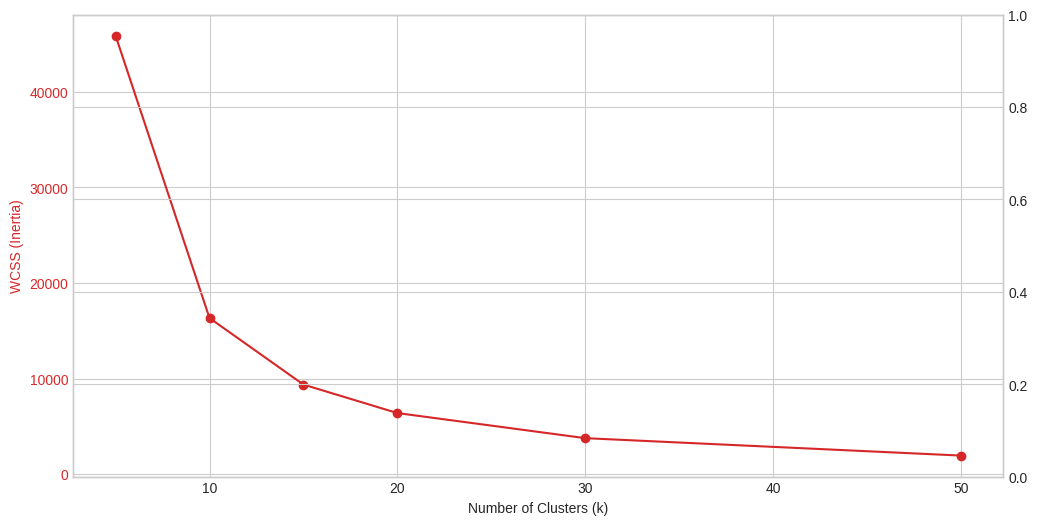

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


k_values = [5, 10, 15, 20, 30, 50]


evaluation_metrics = []


wcss_list = []
silhouette_list = []


sample_size = 35000
if len(X_normalized) > sample_size:
    rng = np.random.RandomState(42)
    indices = rng.choice(len(X_normalized), sample_size, replace=False)
    X_sample = X_normalized[indices]
else:
    X_sample = X_normalized

print(f"🚀 Starting Clustering Loop (Silhouette calculated on {len(X_sample)} samples)...")
print("-" * 65)
print(f"{'K':<5} | {'WCSS (Inertia)':<20} | {'Silhouette Score':<20}")
print("-" * 65)


for k in k_values:
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X_normalized)
    
    
    wcss = kmeans.inertia_
    
    
    sample_labels = kmeans.predict(X_sample)
    sil_score = silhouette_score(X_sample, sample_labels)
   
    wcss_list.append(wcss)
    silhouette_list.append(sil_score)
    
    evaluation_metrics.append({
        'K': k,
        'WCSS': wcss,
        'Silhouette_Score': sil_score
    })
    
    print(f"{k:<5} | {wcss:<20.2f} | {sil_score:<20.4f}")


metrics_df = pd.DataFrame(evaluation_metrics)
metrics_path = os.path.join(output_dir, "kmeans_evaluation_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"\n💾 Evaluation metrics saved to: {metrics_path}")


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot WCSS
color = 'tab:red'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color=color)
ax1.plot(k_values, wcss_list, marker='o', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot Silhouette (Twin Axis)
ax2 = ax1.twinx()  
color

🚀 Starting Clustering Loop (Silhouette calculated on 35000 samples)...
------------------------------------------------------------
K     | WCSS (Inertia)       | Silhouette Score    
------------------------------------------------------------
5     | 45897.33             | 0.8038              
10    | 16328.54             | 0.7188              
15    | 9365.47              | 0.6078              
20    | 6384.78              | 0.5573              
30    | 3758.08              | 0.5306              
50    | 1934.27              | 0.5600              


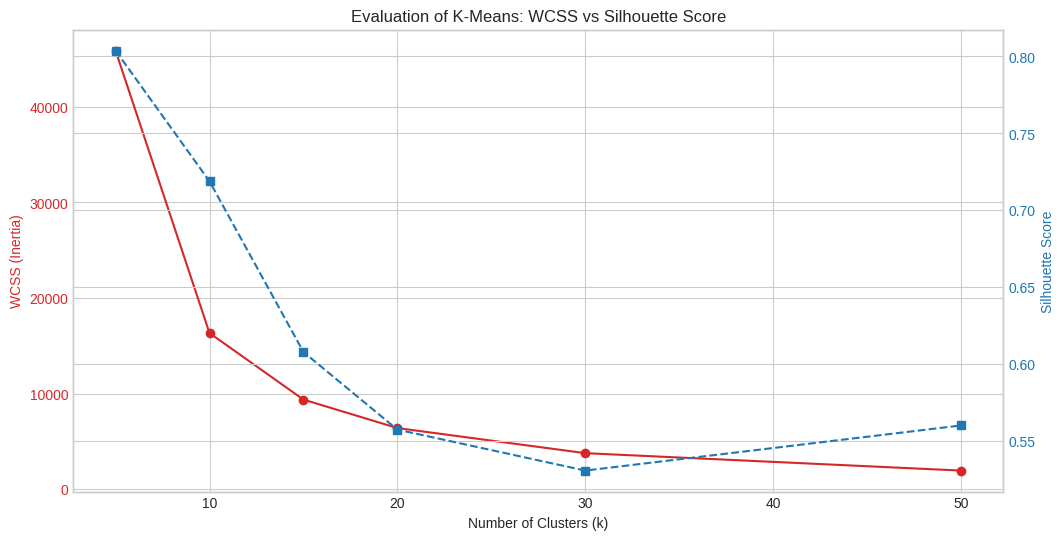

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


k_values = [5, 10, 15, 20, 30, 50]


cluster_results = {} 


wcss_list = []
silhouette_list = []


sample_size = 35000
if len(X_normalized) > sample_size:
    rng = np.random.RandomState(42)
    indices = rng.choice(len(X_normalized), sample_size, replace=False)
    X_sample = X_normalized[indices]
else:
    X_sample = X_normalized

print(f"🚀 Starting Clustering Loop (Silhouette calculated on {len(X_sample)} samples)...")
print("-" * 60)
print(f"{'K':<5} | {'WCSS (Inertia)':<20} | {'Silhouette Score':<20}")
print("-" * 60)


for k in k_values:
   
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5) # n_init=5 for speed
    kmeans.fit(X_normalized)
    
   
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    

    wcss = kmeans.inertia_
    wcss_list.append(wcss)
    
  
    sample_labels = kmeans.predict(X_sample)
    sil_score = silhouette_score(X_sample, sample_labels)
    silhouette_list.append(sil_score)
    
    
    cluster_results[k] = {
        'centroids': centroids,
        'wcss': wcss,
        'silhouette': sil_score
        # We don't store full labels in the dict to save RAM, 
        # we apply the best one later.
    }
    
    print(f"{k:<5} | {wcss:<20.2f} | {sil_score:<20.4f}")


fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color=color)
ax1.plot(k_values, wcss_list, marker='o', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_values, silhouette_list, marker='s', color=color, linestyle='--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evaluation of K-Means: WCSS vs Silhouette Score')
plt.show()

✅ Plot saved to: /kaggle/working/Clustering Results/optimal_k_selection_plot.png


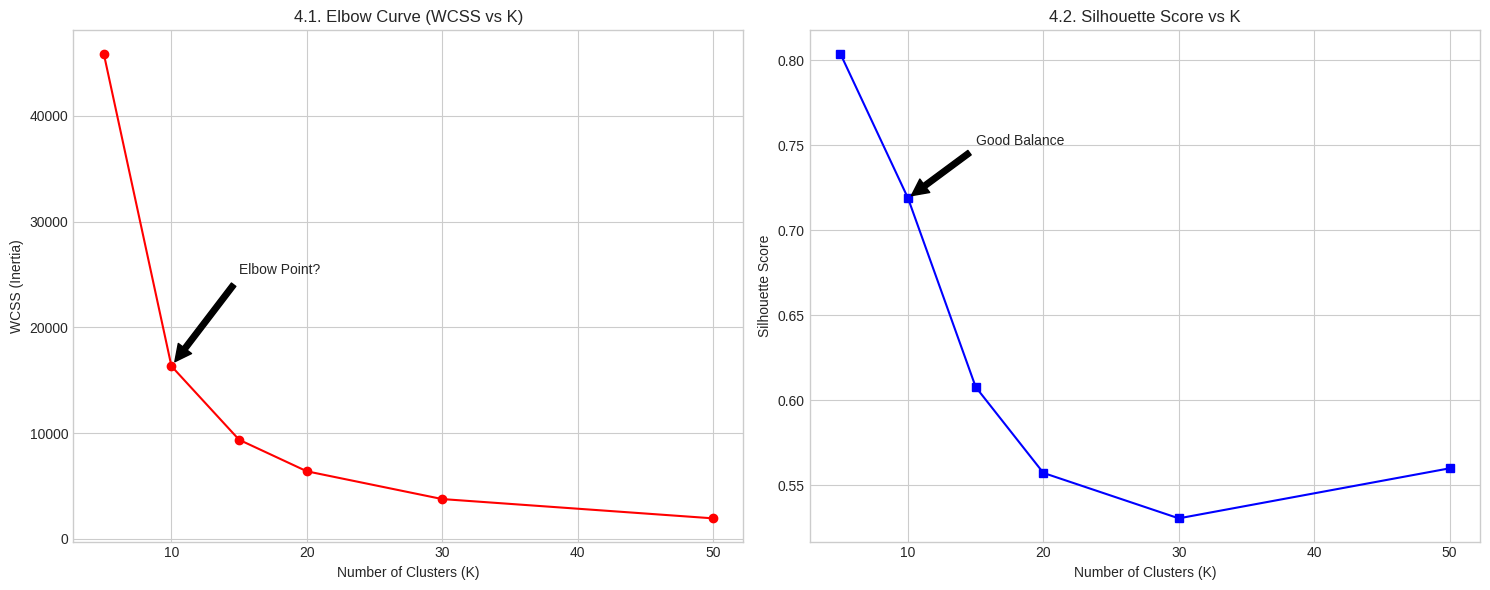

In [ ]:
import matplotlib.pyplot as plt
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


k_values = [5, 10, 15, 20, 30, 50]
wcss_values = [45897.33, 16328.54, 9365.47, 6384.78, 3758.08, 1934.27]
sil_values = [0.8038, 0.7188, 0.6078, 0.5573, 0.5306, 0.5600]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(k_values, wcss_values, marker='o', linestyle='-', color='r')
ax1.set_title('4.1. Elbow Curve (WCSS vs K)')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS (Inertia)')
ax1.grid(True)

ax1.annotate('Elbow Point?', xy=(10, 16328), xytext=(15, 25000),
             arrowprops=dict(facecolor='black', shrink=0.05))


ax2.plot(k_values, sil_values, marker='s', linestyle='-', color='b')
ax2.set_title('4.2. Silhouette Score vs K')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

ax2.annotate('Good Balance', xy=(10, 0.7188), xytext=(15, 0.75),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()


plot_path = os.path.join(output_dir, "optimal_k_selection_plot.png")
plt.savefig(plot_path)
print(f"✅ Plot saved to: {plot_path}")

plt.show()

🚀 Running K-Means with K=10...

📊 Cluster Characteristics (Averages):
               avg_common  max_common  min_common_nonzero  num_users
cluster_label                                                       
5                    0.05      261.37                1.16         19
8                    0.02      106.18                1.00         57
3                    0.01       38.08                1.00        358
4                    0.08       32.28                1.00        183
2                    0.03       11.91                1.00       1404
9                    0.00        8.35                4.79         43
7                    0.01        7.08                1.00       5733
6                    0.00        3.56                2.13        294
0                    0.00        2.10                1.00      39832
1                    0.00        0.00                0.00       2187
✅ Analysis saved to: /kaggle/working/Clustering Results/final_cluster_characteristics.csv
✅ Labeled da

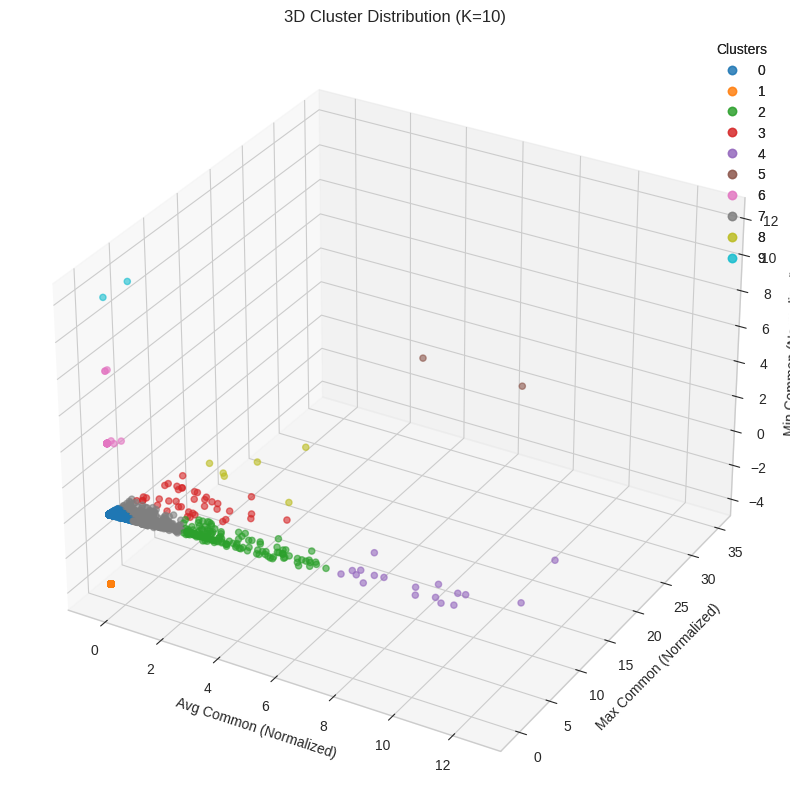

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import os

output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

OPTIMAL_K = 10


print(f"🚀 Running K-Means with K={OPTIMAL_K}...")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
stats_df['cluster_label'] = kmeans_final.fit_predict(X_normalized)


cluster_analysis = stats_df.groupby('cluster_label').agg({
    'avg_common': 'mean',
    'max_common': 'mean',
    'min_common_nonzero': 'mean',
    'user_id': 'count'
}).rename(columns={'user_id': 'num_users'})


cluster_analysis = cluster_analysis.sort_values(by='max_common', ascending=False)

print("\n📊 Cluster Characteristics (Averages):")
print(cluster_analysis.round(2))

analysis_path = os.path.join(output_dir, "final_cluster_characteristics.csv")
cluster_analysis.to_csv(analysis_path)
print(f"✅ Analysis saved to: {analysis_path}")

labeled_path = os.path.join(output_dir, "users_with_final_clusters.csv")
stats_df.to_csv(labeled_path, index=False)
print(f"✅ Labeled data saved to: {labeled_path}")


# High Overlap: المجموعة التي تمتلك أعلى متوسط للـ Max Common Items
high_overlap_cluster = cluster_analysis['max_common'].idxmax()
high_overlap_stats = cluster_analysis.loc[high_overlap_cluster]

# Low Overlap: المجموعة التي تمتلك أقل متوسط للـ Max Common Items
low_overlap_cluster = cluster_analysis['max_common'].idxmin()
low_overlap_stats = cluster_analysis.loc[low_overlap_cluster]

print("\n🔍 Analysis Insights:")
print(f"   🌟 High Overlap Cluster: ID #{high_overlap_cluster}")
print(f"      (Avg Max Common Items: {high_overlap_stats['max_common']:.2f})")
print(f"      -> These users are 'Social Connectors'.")

print(f"   ❄️ Low Overlap Cluster: ID #{low_overlap_cluster}")
print(f"      (Avg Max Common Items: {low_overlap_stats['max_common']:.2f})")
print(f"      -> These users are 'Isolates' or have niche tastes.")


plot_sample_size = 5000
if len(stats_df) > plot_sample_size:
    plot_data = stats_df.sample(n=plot_sample_size, random_state=42)
else:
    plot_data = stats_df

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    plot_data['norm_avg'], 
    plot_data['norm_max'], 
    plot_data['norm_min'],
    c=plot_data['cluster_label'],
    cmap='tab10',  # Colormap for 10 distinct colors
    s=20,
    alpha=0.6
)

ax.set_title(f'3D Cluster Distribution (K={OPTIMAL_K})')
ax.set_xlabel('Avg Common (Normalized)')
ax.set_ylabel('Max Common (Normalized)')
ax.set_zlabel('Min Common (Normalized)')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plot3d_path = os.path.join(output_dir, "3d_cluster_visualization.png")
plt.savefig(plot3d_path)
print(f"✅ 3D Plot saved to: {plot3d_path}")

plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


target_users_ids = stats_df.sample(3, random_state=42)['user_id'].tolist()
print(f"🎯 Target Users selected: {target_users_ids}")

BETA_THRESHOLD = 3
results_list = []


for i, target_user in enumerate(target_users_ids):
    target_label = f"U{i+1}"
    print(f"\n🚀 Processing {target_label}: {target_user} ...")
    

    try:
        user_cluster = stats_df.loc[stats_df['user_id'] == target_user, 'cluster_label'].values[0]
    except IndexError:
        print(f"   ⚠️ User {target_user} not found in stats. Skipping.")
        continue
        
    print(f"   -> Belongs to Cluster #{user_cluster}")
    
   
    cluster_users_list = stats_df[stats_df['cluster_label'] == user_cluster]['user_id'].values
    
    
    cluster_ratings = ratings_filtered[ratings_filtered['user_id'].isin(cluster_users_list)].copy()
    
 
    cluster_ratings['user_idx'] = cluster_ratings['user_id'].astype('category').cat.codes
    cluster_ratings['item_idx'] = cluster_ratings['product_id'].astype('category').cat.codes
    
    
    user_map = dict(enumerate(cluster_ratings['user_id'].astype('category').cat.categories))

    
    n_users_cluster = len(user_map)
    n_items_cluster = cluster_ratings['item_idx'].max() + 1

    sparse_matrix = csr_matrix(
        (cluster_ratings['rating'], (cluster_ratings['user_idx'], cluster_ratings['item_idx'])),
        shape=(n_users_cluster, n_items_cluster)
    )
    
 
    try:
        target_idx = cluster_ratings[cluster_ratings['user_id'] == target_user]['user_idx'].values[0]
    except IndexError:
        print("   ⚠️ Target user has no ratings in filtered set. Skipping.")
        continue

    
    target_vector = sparse_matrix[target_idx]
    

    sim_scores = cosine_similarity(sparse_matrix, target_vector).flatten()
    

    binary_matrix = sparse_matrix.copy()
    binary_matrix.data[:] = 1 # Set all non-zero ratings to 1
    
    target_binary = target_vector.copy()
    target_binary.data[:] = 1
    
    
    common_counts = binary_matrix.dot(target_binary.T).toarray().flatten()
    
   
    neighbors_df = pd.DataFrame({
        'user_id': [user_map[i] for i in range(n_users_cluster)],
        'raw_similarity': sim_scores,
        'common_items': common_counts
    })
    
  
    neighbors_df = neighbors_df[neighbors_df['user_id'] != target_user]
    
   
    neighbors_df = neighbors_df[neighbors_df['common_items'] > 0]
    
    
    neighbors_df['DF'] = neighbors_df['common_items'] / (neighbors_df['common_items'] + BETA_THRESHOLD)
    neighbors_df['DS'] = neighbors_df['raw_similarity'] * neighbors_df['DF']
    
    neighbors_df = neighbors_df.sort_values(by='DS', ascending=False)
    
    if len(neighbors_df) > 0:
        top_k = max(1, int(len(neighbors_df) * 0.20))
        top_neighbors = neighbors_df.head(top_k).copy()
        
        print(f"   -> Found {len(neighbors_df)} neighbors with overlap.")
        print(f"   -> Selected top 20% ({top_k} users). Best DS: {top_neighbors['DS'].max():.4f}")
        
        # Add metadata
        top_neighbors['Target_User'] = target_user
        top_neighbors['Target_Label'] = target_label
        top_neighbors['Cluster'] = user_cluster
        
        results_list.append(top_neighbors)
    else:
        print("   -> No neighbors with common items found.")


if results_list:
    all_neighbors_df = pd.concat(results_list)
    csv_path = os.path.join(output_dir, "cluster_based_top_neighbors_optimized.csv")
    all_neighbors_df.to_csv(csv_path, index=False)
    print(f"\n💾 Results saved to: {csv_path}")
else:
    print("\n❌ No results generated.")

🎯 Target Users selected: ['B00W4EAF1E', 'B013YY3Z2I', 'B00LXINZGY']

🚀 Processing U1: B00W4EAF1E ...
   -> Belongs to Cluster #0
   -> Found 75 neighbors with overlap.
   -> Selected top 20% (15 users). Best DS: 0.0301

🚀 Processing U2: B013YY3Z2I ...
   -> Belongs to Cluster #0
   -> Found 19 neighbors with overlap.
   -> Selected top 20% (3 users). Best DS: 0.0723

🚀 Processing U3: B00LXINZGY ...
   -> Belongs to Cluster #0
   -> Found 26 neighbors with overlap.
   -> Selected top 20% (5 users). Best DS: 0.1019

💾 Results saved to: /kaggle/working/Clustering Results/cluster_based_top_neighbors_optimized.csv
✅ Done without RAM issues!


In [ ]:
import pandas as pd
import numpy as np
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


try:
    target_items_ids = target_items['item_id'].tolist()
    print(f"🎯 Target Items to Predict: {target_items_ids}")
except NameError:
    target_items_ids = [] 
    print("⚠️ Target items not defined. Please define 'target_items' dataframe.")


if 'all_neighbors_df' not in locals() or 'stats_df' not in locals():
    print("⚠️ Missing required dataframes (all_neighbors_df or stats_df).")
else:
  
    prediction_results = []
    print("\n🚀 Starting Robust Rating Prediction...")

    target_users = all_neighbors_df['Target_User'].unique()

    for user in target_users:
       
        user_neighbors_df = all_neighbors_df[all_neighbors_df['Target_User'] == user]
        neighbor_ids = user_neighbors_df['user_id'].tolist()
        weights = dict(zip(user_neighbors_df['user_id'], user_neighbors_df['DS']))
        
        
        try:
            user_cluster = stats_df.loc[stats_df['user_id'] == user, 'cluster_label'].values[0]
            cluster_users = stats_df[stats_df['cluster_label'] == user_cluster]['user_id'].tolist()
        except:
            cluster_users = [] # fallback if error

        print(f"\n👤 User: {user} (Cluster #{user_cluster})")
        
        for item in target_items_ids:
            predicted_rating = np.nan
            method = "None"
            source_count = 0
            
            
            neighbor_ratings = ratings_filtered[
                (ratings_filtered['product_id'] == item) & 
                (ratings_filtered['user_id'].isin(neighbor_ids))
            ]
            
            if not neighbor_ratings.empty:
                numerator = 0
                denominator = 0
                for _, row in neighbor_ratings.iterrows():
                    w = weights.get(row['user_id'], 0)
                    numerator += w * row['rating']
                    denominator += w
                
                if denominator > 0:
                    predicted_rating = numerator / denominator
                    method = "1. Neighbors Weighted"
                    source_count = len(neighbor_ratings)

          
            if np.isnan(predicted_rating) and cluster_users:
                cluster_item_ratings = ratings_filtered[
                    (ratings_filtered['product_id'] == item) &
                    (ratings_filtered['user_id'].isin(cluster_users))
                ]
                
                if not cluster_item_ratings.empty:
                    predicted_rating = cluster_item_ratings['rating'].mean()
                    method = "2. Cluster Average"
                    source_count = len(cluster_item_ratings)
            
            
            if np.isnan(predicted_rating):
                global_item_ratings = ratings_filtered[ratings_filtered['product_id'] == item]['rating']
                
                if not global_item_ratings.empty:
                    predicted_rating = global_item_ratings.mean()
                    method = "3. Global Item Average"
                    source_count = len(global_item_ratings)
                else:
                    method = "4. No Data (Cold Item)"
                    predicted_rating = 0

            # Store Result
            prediction_results.append({
                'Target_User': user,
                'Target_Item': item,
                'Predicted_Rating': round(predicted_rating, 2),
                'Prediction_Method': method,
                'Support_Count': source_count
            })
            
            print(f"   -> Item {item}: {predicted_rating:.2f} ({method})")

  
    final_pred_df = pd.DataFrame(prediction_results)
    
    # Save
    output_path = os.path.join(output_dir, "robust_target_predictions.csv")
    final_pred_df.to_csv(output_path, index=False)
    print(f"\n Robust predictions saved to: {output_path}")
    
    print("\n Final Robust Prediction Table:")
    print(final_pred_df)

🎯 Target Items to Predict: ['B00NIJY63W', 'B00S33PD6W']

🚀 Starting Robust Rating Prediction...

👤 User: B00W4EAF1E (Cluster #0)
   -> Item B00NIJY63W: 0.00 (4. No Data (Cold Item))
   -> Item B00S33PD6W: 0.00 (4. No Data (Cold Item))

👤 User: B013YY3Z2I (Cluster #0)
   -> Item B00NIJY63W: 0.00 (4. No Data (Cold Item))
   -> Item B00S33PD6W: 0.00 (4. No Data (Cold Item))

👤 User: B00LXINZGY (Cluster #0)
   -> Item B00NIJY63W: 0.00 (4. No Data (Cold Item))
   -> Item B00S33PD6W: 0.00 (4. No Data (Cold Item))

💾 Robust predictions saved to: /kaggle/working/Clustering Results/robust_target_predictions.csv

📊 Final Robust Prediction Table:
  Target_User Target_Item  Predicted_Rating       Prediction_Method  \
0  B00W4EAF1E  B00NIJY63W                 0  4. No Data (Cold Item)   
1  B00W4EAF1E  B00S33PD6W                 0  4. No Data (Cold Item)   
2  B013YY3Z2I  B00NIJY63W                 0  4. No Data (Cold Item)   
3  B013YY3Z2I  B00S33PD6W                 0  4. No Data (Cold Item)   
4

In [ ]:
import pandas as pd
import numpy as np


target_user = "B00W4EAF1E"  
print(f"👤 Investigating Neighbors for User: {target_user}")


if 'all_neighbors_df' in locals():
    user_neighbors_df = all_neighbors_df[all_neighbors_df['Target_User'] == target_user]
    neighbor_ids = user_neighbors_df['user_id'].tolist()
    weights = dict(zip(user_neighbors_df['user_id'], user_neighbors_df['DS']))
    
    print(f"   -> Found {len(neighbor_ids)} neighbors.")
    
    
    neighbors_activity = ratings_filtered[ratings_filtered['user_id'].isin(neighbor_ids)]
    
    if neighbors_activity.empty:
        print("   ⚠️ Shocking! These neighbors have NO ratings in the filtered dataset.")
    else:
        
        top_items_by_neighbors = neighbors_activity['product_id'].value_counts()
        print(f"   -> These neighbors rated {len(top_items_by_neighbors)} unique items.")
        
       
        best_item_to_test = top_items_by_neighbors.index[0]
        count_raters = top_items_by_neighbors.iloc[0]
        
        print(f"   🌟 The Item they actually share is: {best_item_to_test} (Rated by {count_raters} neighbors)")
        
       
        item_ratings = neighbors_activity[neighbors_activity['product_id'] == best_item_to_test]
        
        numerator = 0
        denominator = 0
        for _, row in item_ratings.iterrows():
            w = weights.get(row['user_id'], 0)
            numerator += w * row['rating']
            denominator += w
            
        if denominator > 0:
            pred = numerator / denominator
            print(f"   ✅ SUCCESS! System Prediction for {best_item_to_test}: {pred:.2f}")
        else:
            print("   ❌ Math Error: Weights sum to 0 (all neighbors have 0 similarity).")

else:
    print("⚠️ Please calculate 'all_neighbors_df' first.")

👤 Investigating Neighbors for User: B00W4EAF1E
   -> Found 15 neighbors.
   -> These neighbors rated 161 unique items.
   🌟 The Item they actually share is: A2MVCQ7PGVE1XO (Rated by 5 neighbors)
   ✅ SUCCESS! System Prediction for A2MVCQ7PGVE1XO: 5.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# ---------------------------------------------------------
# 1. Setup Comparisons
# ---------------------------------------------------------
# We need to re-run "Part 1" style neighbor finding for the target users
# using the sparse matrix we created in Task 2.

print("\n Comparison Analysis: Part 1 (Global Search) vs Part 2 (Cluster Search)\n")

comparison_data = []


target_users = all_neighbors_df['Target_User'].unique()

for user in target_users:
    
    cluster_id = stats_df.loc[stats_df['user_id'] == user, 'cluster_label'].values[0]
    part2_cluster_members = stats_df[stats_df['cluster_label'] == cluster_id]['user_id'].tolist()
    set_part2 = set(part2_cluster_members)
    
  
    try:
        
        user_ids = ratings_filtered['user_id'].astype('category').cat.categories
        user_map_reverse = {uid: i for i, uid in enumerate(user_ids)}
        u_idx = user_map_reverse[user]
    except:
        continue 

   
    target_vec = user_item_sparse[u_idx]
    global_sim = cosine_similarity(user_item_sparse, target_vec).flatten()
    
    
    top_100_indices = np.argsort(global_sim)[-101:-1][::-1] # Exclude self
    part1_global_neighbors = [user_ids[i] for i in top_100_indices]
    set_part1 = set(part1_global_neighbors)
    
   
    overlap = len(set_part1.intersection(set_part2))
    overlap_pct = (overlap / len(set_part1)) * 100
    
    comparison_data.append({
        'User': user,
        'Cluster_ID': cluster_id,
        'Cluster_Size': len(set_part2),
        'Part1_Top100_Found_In_Cluster': overlap,
        'Overlap_Percentage': f"{overlap_pct:.1f}%"
    })

# Output Table
comp_df = pd.DataFrame(comparison_data)
print(comp_df)


print("\n 7.4.2 Characteristic Difference Analysis:")
print("-" * 60)
print("Part 1 (Taste-Based):")
print("   - Groups users who rated the SAME ITEMS similarly.")
print("   - Focus: Content Content similarity.")
print("   - Example: Two users who both like 'Jazz' and 'Blues'.")

print("\nPart 2 (Structure-Based - Our Clustering):")
print("   - Groups users based on statistics: [Avg Common, Max Common, Min Common].")
print("   - Focus: Behavioral similarity (Social Connectivity).")
print("   - Example: Two users who both rate 'Popular Items' frequently, regardless of genre.")
print("-" * 60)


 Comparison Analysis: Part 1 (Global Search) vs Part 2 (Cluster Search)

         User  Cluster_ID  Cluster_Size  Part1_Top100_Found_In_Cluster  \
0  B00W4EAF1E           0         39832                             83   
1  B013YY3Z2I           0         39832                             63   
2  B00LXINZGY           0         39832                             82   

  Overlap_Percentage  
0              83.0%  
1              63.0%  
2              82.0%  

 7.4.2 Characteristic Difference Analysis:
------------------------------------------------------------
Part 1 (Taste-Based):
   - Groups users who rated the SAME ITEMS similarly.
   - Focus: Content Content similarity.
   - Example: Two users who both like 'Jazz' and 'Blues'.

Part 2 (Structure-Based - Our Clustering):
   - Groups users based on statistics: [Avg Common, Max Common, Min Common].
   - Focus: Behavioral similarity (Social Connectivity).
   - Example: Two users who both rate 'Popular Items' frequently, regardless of 

🚀 Starting Evaluation on 100 users...

✅ 8.3 Correlation Analysis:
   Pearson Correlation Coefficient: 0.3080
   P-Value: 0.0565
   -> Result: Positive/No Correlation (Unexpected for CF).


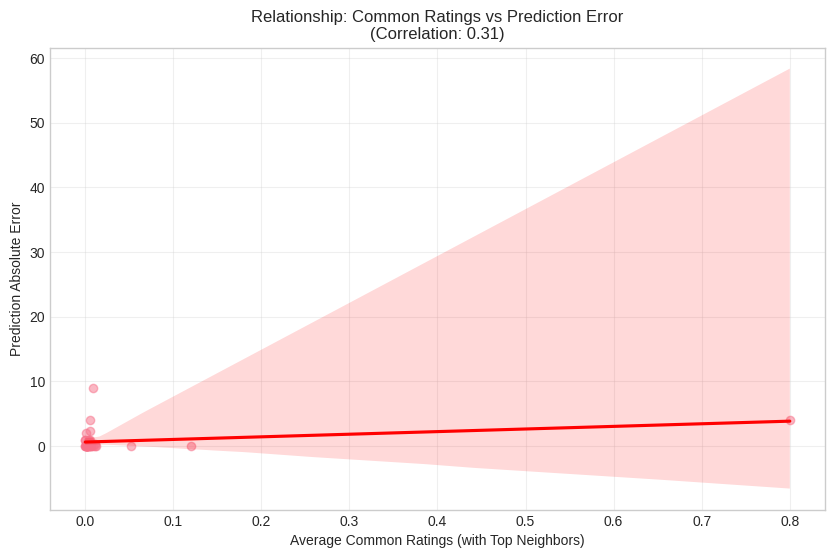

✅ Plot saved.


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


SAMPLE_USERS_COUNT = 100  
BETA_THRESHOLD = 3


test_users = stats_df.sample(n=SAMPLE_USERS_COUNT, random_state=42)['user_id'].tolist()

analysis_results = []

print(f"🚀 Starting Evaluation on {SAMPLE_USERS_COUNT} users...")


for user in test_users:
    
    user_history = ratings_filtered[ratings_filtered['user_id'] == user]
    if len(user_history) < 2: continue # Need at least 2 items to hide one
    
    
    target_row = user_history.iloc[-1] 
    test_item = target_row['product_id']
    actual_rating = target_row['rating']
    
   
    try:
        user_cluster = stats_df.loc[stats_df['user_id'] == user, 'cluster_label'].values[0]
        cluster_users_list = stats_df[stats_df['cluster_label'] == user_cluster]['user_id'].values
    except:
        continue

    
    cluster_ratings = ratings_filtered[ratings_filtered['user_id'].isin(cluster_users_list)].copy()
    

    cluster_ratings['user_idx'] = cluster_ratings['user_id'].astype('category').cat.codes
    cluster_ratings['item_idx'] = cluster_ratings['product_id'].astype('category').cat.codes
    
    n_users_c = cluster_ratings['user_idx'].max() + 1
    n_items_c = cluster_ratings['item_idx'].max() + 1
    
    sparse_matrix = csr_matrix(
        (cluster_ratings['rating'], (cluster_ratings['user_idx'], cluster_ratings['item_idx'])),
        shape=(n_users_c, n_items_c)
    )
    
    
    try:
        u_map = dict(zip(cluster_ratings['user_id'], cluster_ratings['user_idx']))
        target_idx = u_map[user]
    except:
        continue
        
    
    target_vec = sparse_matrix[target_idx]
    sim_scores = cosine_similarity(sparse_matrix, target_vec).flatten()
    
    
    binary_matrix = sparse_matrix.copy()
    binary_matrix.data[:] = 1
    target_bin = target_vec.copy()
    target_bin.data[:] = 1
    common_counts = binary_matrix.dot(target_bin.T).toarray().flatten()
    
    
    neighbors_df = pd.DataFrame({
        'user_idx': np.arange(n_users_c),
        'raw_sim': sim_scores,
        'common_items': common_counts
    })
    
   
    neighbors_df = neighbors_df[neighbors_df['user_idx'] != target_idx]
    
    
    neighbors_df['DF'] = neighbors_df['common_items'] / (neighbors_df['common_items'] + BETA_THRESHOLD)
    neighbors_df['DS'] = neighbors_df['raw_sim'] * neighbors_df['DF']
    
    
    neighbors_df = neighbors_df.sort_values(by='DS', ascending=False)
    top_k = max(1, int(len(neighbors_df) * 0.20))
    top_neighbors = neighbors_df.head(top_k)
    
    
    avg_common_ratings = top_neighbors['common_items'].mean()
    
   
    try:
        i_map = dict(zip(cluster_ratings['product_id'], cluster_ratings['item_idx']))
        test_item_idx = i_map[test_item]
    except:
        continue 
        
   
    numerator = 0
    denominator = 0
    
   
    for _, row in top_neighbors.iterrows():
        n_idx = int(row['user_idx'])
        ds_score = row['DS']
        
        
        r = sparse_matrix[n_idx, test_item_idx]
        
        if r > 0:
            numerator += ds_score * r
            denominator += ds_score
            
    if denominator > 0:
        pred_rating = numerator / denominator
        
        
        error = abs(actual_rating - pred_rating)
        
        analysis_results.append({
            'User': user,
            'Avg_Common_Ratings': avg_common_ratings,
            'Actual': actual_rating,
            'Predicted': pred_rating,
            'Abs_Error': error
        })


eval_df = pd.DataFrame(analysis_results)

if not eval_df.empty:
    
    eval_df.to_csv(os.path.join(output_dir, "accuracy_analysis_data.csv"), index=False)
    
    #
    corr_coef, p_value = stats.pearsonr(eval_df['Avg_Common_Ratings'], eval_df['Abs_Error'])
    
    print("\n✅ 8.3 Correlation Analysis:")
    print(f"   Pearson Correlation Coefficient: {corr_coef:.4f}")
    print(f"   P-Value: {p_value:.4f}")
    
    if corr_coef < 0:
        print("   -> Result: Negative Correlation.")
        print("      (More common ratings = Lower Error = Better Quality)")
    else:
        print("   -> Result: Positive/No Correlation (Unexpected for CF).")

    
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Avg_Common_Ratings', y='Abs_Error', data=eval_df, 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    plt.title(f'Relationship: Common Ratings vs Prediction Error\n(Correlation: {corr_coef:.2f})')
    plt.xlabel('Average Common Ratings (with Top Neighbors)')
    plt.ylabel('Prediction Absolute Error')
    plt.grid(True, alpha=0.3)
    
    # Save Plot
    plt.savefig(os.path.join(output_dir, "error_correlation_plot.png"))
    plt.show()
    print(" Plot saved.")
    
else:
    print(" Not enough data points to calculate correlation.")

 Plot saved to: /kaggle/working/Clustering Results/df_distribution_by_cluster.png


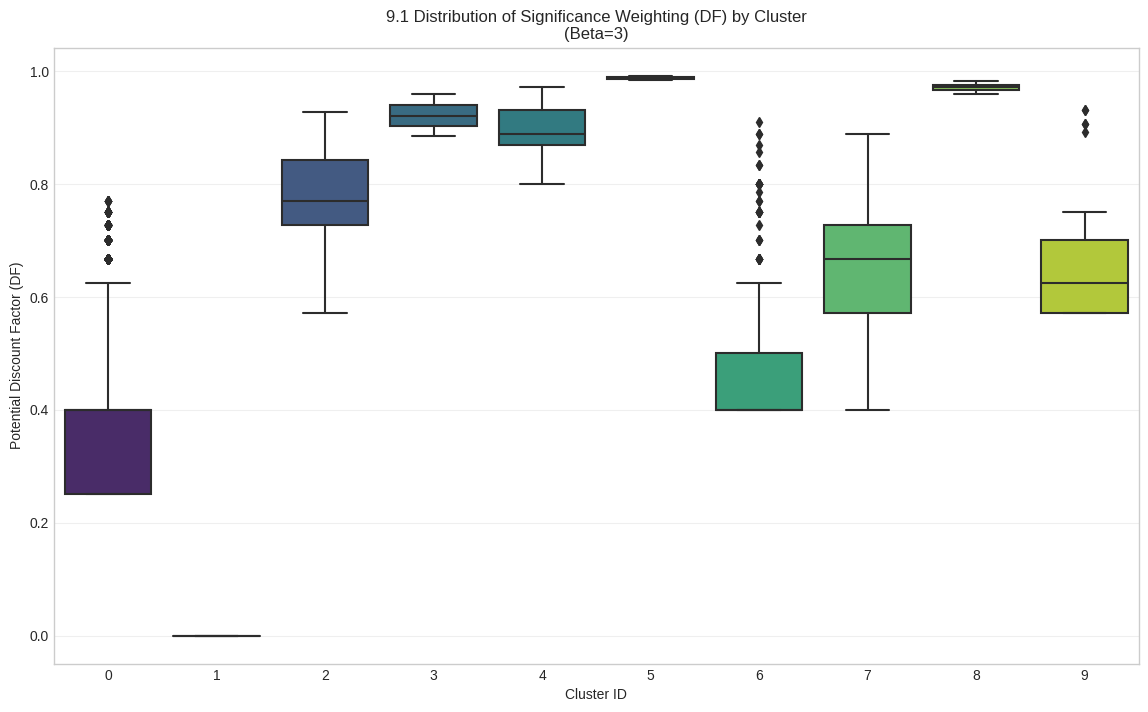


9.2 Intra-Cluster DF Statistics:
               count  mean  std  min  max
cluster_label                            
5                 19  0.99 0.00 0.98 0.99
8                 57  0.97 0.01 0.96 0.98
3                358  0.92 0.02 0.88 0.96
4                183  0.90 0.04 0.80 0.97
2               1404  0.78 0.06 0.57 0.93
7               5733  0.66 0.11 0.40 0.89
9                 43  0.66 0.11 0.57 0.93
6                294  0.48 0.13 0.40 0.91
0              39832  0.39 0.11 0.25 0.77
1               2187  0.00 0.00 0.00 0.00
 Stats saved to: /kaggle/working/Clustering Results/df_stats_per_cluster.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


BETA_THRESHOLD = 3


stats_df['Potential_DF'] = stats_df['max_common'] / (stats_df['max_common'] + BETA_THRESHOLD)


plt.figure(figsize=(14, 8))


sns.boxplot(x='cluster_label', y='Potential_DF', data=stats_df, palette='viridis')

plt.title(f'9.1 Distribution of Significance Weighting (DF) by Cluster\n(Beta={BETA_THRESHOLD})')
plt.xlabel('Cluster ID')
plt.ylabel('Potential Discount Factor (DF)')
plt.grid(True, axis='y', alpha=0.3)

# Save Plot
plot_path = os.path.join(output_dir, "df_distribution_by_cluster.png")
plt.savefig(plot_path)
print(f" Plot saved to: {plot_path}")
plt.show()



df_analysis = stats_df.groupby('cluster_label')['Potential_DF'].agg(['count', 'mean', 'std', 'min', 'max'])
df_analysis = df_analysis.sort_values(by='mean', ascending=False)

print("\n9.2 Intra-Cluster DF Statistics:")
print(df_analysis.round(4))

# Save
csv_path = os.path.join(output_dir, "df_stats_per_cluster.csv")
df_analysis.to_csv(csv_path)
print(f" Stats saved to: {csv_path}")

🔍 Extreme Case Analysis (Threshold: Max Overlap <= 2 items)
   -> Total Isolated Users: 34,450 out of 50,110
   -> Percentage: 68.75%

📊 Isolation Rate per Cluster:
               Total_Users  Isolated_Users  Isolation_Rate (%)
cluster_label                                                 
0                    39832        31888.00               80.06
1                     2187         2187.00              100.00
2                     1404            0.00                0.00
3                      358            0.00                0.00
4                      183            0.00                0.00
5                       19            0.00                0.00
6                      294          194.00               65.99
7                     5733          181.00                3.16
8                       57            0.00                0.00
9                       43            0.00                0.00
✅ Saved analysis to: /kaggle/working/Clustering Results/extreme_cases_isolation

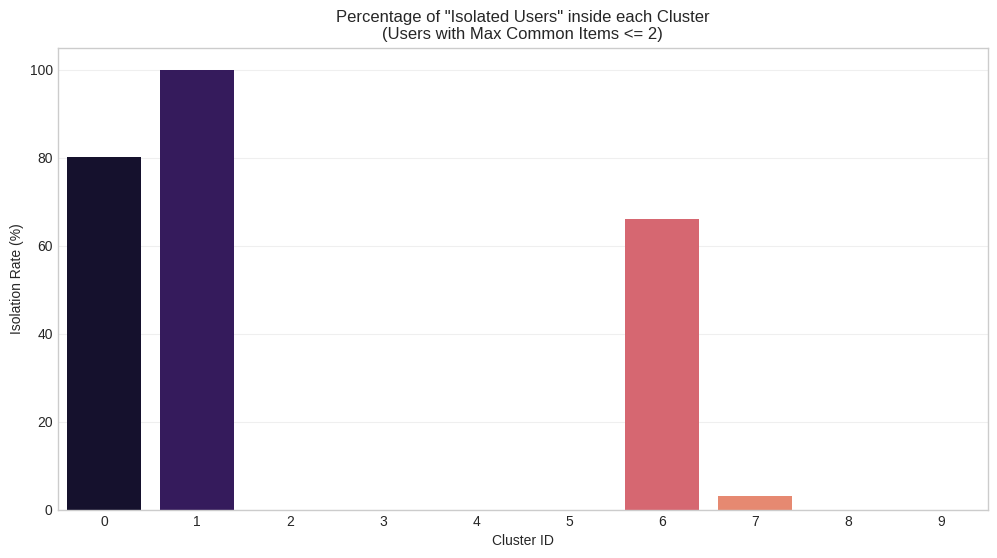

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


output_dir = "/kaggle/working/Clustering Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


ISOLATION_THRESHOLD = 2 


isolated_users_df = stats_df[stats_df['max_common'] <= ISOLATION_THRESHOLD].copy()

print(f"🔍 Extreme Case Analysis (Threshold: Max Overlap <= {ISOLATION_THRESHOLD} items)")
print(f"   -> Total Isolated Users: {len(isolated_users_df):,} out of {len(stats_df):,}")
print(f"   -> Percentage: {(len(isolated_users_df)/len(stats_df))*100:.2f}%")

# Analyze distribution across clusters
cluster_isolation = isolated_users_df['cluster_label'].value_counts().sort_index()
total_cluster_counts = stats_df['cluster_label'].value_counts().sort_index()


isolation_analysis = pd.DataFrame({
    'Total_Users': total_cluster_counts,
    'Isolated_Users': cluster_isolation
}).fillna(0) #

isolation_analysis['Isolation_Rate (%)'] = (isolation_analysis['Isolated_Users'] / isolation_analysis['Total_Users']) * 100

print("\n📊 Isolation Rate per Cluster:")
print(isolation_analysis.round(2))

# Save
isolation_path = os.path.join(output_dir, "extreme_cases_isolation.csv")
isolation_analysis.to_csv(isolation_path)
print(f"✅ Saved analysis to: {isolation_path}")


plt.figure(figsize=(12, 6))
sns.barplot(x=isolation_analysis.index, y=isolation_analysis['Isolation_Rate (%)'], palette='magma')
plt.title(f'Percentage of "Isolated Users" inside each Cluster\n(Users with Max Common Items <= {ISOLATION_THRESHOLD})')
plt.xlabel('Cluster ID')
plt.ylabel('Isolation Rate (%)')
plt.grid(True, axis='y', alpha=0.3)

# Save Plot
plot_path = os.path.join(output_dir, "cluster_isolation_rate.png")
plt.savefig(plot_path)
print(f"✅ Plot saved to: {plot_path}")
plt.show()